In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 59 kB 6.6 MB/s 
     |████████████████████████████████| 3.3 MB 61.7 MB/s 
     |████████████████████████████████| 895 kB 76.6 MB/s 
     |████████████████████████████████| 596 kB 77.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
from tqdm import tqdm
import os

In [4]:
train = pd.read_table('/content/drive/MyDrive/cakd3_colab/2nd_project/datasets/final_train.txt', names = ['label', 'comment'])
validation = pd.read_table('/content/drive/MyDrive/cakd3_colab/2nd_project/datasets/final_validation.txt', names = ['label', 'comment'])
test = pd.read_table('/content/drive/MyDrive/cakd3_colab/2nd_project/datasets/final_test.txt', names = ['label', 'comment'])
train.head()

,label,comment
0,0,동물보다 동물 모형이 더 많아요!
1,0,아....방학이라 사람이 넘 많아요. 대기시간 180분. 헐
2,0,공원도 뭣도 아닌 곳사람이 지나다니는 길에 콘크리트 화분이 수백개미치지 않고서야어찌...
3,0,생각보다 다양하거나 크진않았던거같아요ㅜ
4,0,남대문 시장에 가는것은 순전히 갈치조림 먹는거랑 지나가는길에 가는 정도!! 사실 크...


In [5]:
# 버트 인풋 만들기

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [13]:
# 네이버 영화 평가 문장들을 버트 인풋으로 변환
def convert_data(data_df):
  global tokenizer

  SEQ_LEN = 250 # 버트 인풋 길이

  tokens, masks, segments, targets = [], [], [], []

  for i in tqdm(range(len(data_df))):
    # 토큰 인풋
    token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length = SEQ_LEN, truncation = True, padding = 'max_length')

    # 마스크 인풋
    num_zeros = token.count(0)
    mask = [1] * (SEQ_LEN - num_zeros) + [0] * num_zeros 

    # 세그먼트 인풋
    segment = [0] * SEQ_LEN

    tokens.append(token)
    masks.append(mask)
    segments.append(segment)

    targets.append(data_df[LABEL_COLUMN][i])

  # 배열로 바꾸기
  tokens = np.array(tokens)
  masks = np.array(masks)
  segments = np.array(segments)
  targets = np.array(targets)

  return [tokens, masks, segments], targets

# convert_data를 불러오는 함수
def load_data(pandas_dataframe):
  data_df = pandas_dataframe
  data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
  data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
  data_x, data_y = convert_data(data_df)
  return data_x, data_y

SEQ_LEN = 250
BATCH_SIZE = 20

DATA_COLUMN = 'comment'
LABEL_COLUMN = 'label'

train_x, train_y = load_data(train)

100%|██████████| 9600/9600 [00:05<00:00, 1916.45it/s]


In [14]:
validation_x, validation_y = load_data(validation)

100%|██████████| 1200/1200 [00:00<00:00, 1930.07it/s]


In [15]:
test_x, test_y = load_data(test)

100%|██████████| 1200/1200 [00:00<00:00, 1883.00it/s]


In [23]:
from tensorflow.keras.utils import to_categorical

train_y = to_categorical(train_y)
validation_y = to_categorical(validation_y)
test_y = to_categorical(test_y)

In [24]:
# 버트를 활용한 감성분석 모델 만들기
# TPU 객체 지정
TPU = True
if TPU:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu = 'grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
else:
  pass

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.59.3.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.3.234:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [25]:
# Rectified Adam 옵티마이저 사용
!pip install tensorflow_addons
import tensorflow_addons as tfa
opt = tfa.optimizers.RectifiedAdam(learning_rate = 1.0e-5, weight_decay = 0.0025, warmup_proportion = 0.05)

In [26]:
# 감성 분석에 맞는 버트 모형을 리턴하는 함수
def create_sentiment_bert():
  model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
  token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
  mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
  segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
  bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

  bert_outputs = bert_outputs[1]
  sentiment_first = tf.keras.layers.Dense(3, activation = 'softmax', 
                                          kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02))(bert_outputs)
  sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)
  sentiment_model.compile(optimizer = opt, 
                          loss = tf.keras.losses.BinaryCrossentropy(),
                          metrics = ['accuracy'])
  return sentiment_model

In [27]:
# TPU 실행 시
if TPU:
  strategy = tf.distribute.TPUStrategy(resolver)
  with strategy.scope():
    sentiment_model = create_sentiment_bert()
  sentiment_model.fit(train_x, train_y,
                      epochs = 10, shuffle = True, batch_size = 100,
                      validation_data = (validation_x, validation_y))
else: # GPU
  sentiment_model = create_sentiment_bert()
  sentiment_model.fit(train_x, train_y,
                      epochs = 10, shuffle = True, batch_size = 100,
                      validation_data = (validation_x, validation_y))  

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 3) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 3) dtype=float32>]


96/96 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.3970

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 3) dtype=float32>]


96/96 [==============================] - 141s 372ms/step - loss: 0.6452 - accuracy: 0.3970 - val_loss: 0.6023 - val_accuracy: 0.4892
Epoch 2/10
96/96 [==============================] - 24s 246ms/step - loss: 0.5417 - accuracy: 0.6113 - val_loss: 0.4598 - val_accuracy: 0.7308
Epoch 3/10
96/96 [==============================] - 24s 246ms/step - loss: 0.4232 - accuracy: 0.7335 - val_loss: 0.3794 - val_accuracy: 0.7633
Epoch 4/10
96/96 [==============================] - 24s 246ms/step - loss: 0.3511 - accuracy: 0.7887 - val_loss: 0.3414 - val_accuracy: 0.7992
Epoch 5/10
96/96 [==============================] - 24s 246ms/step - loss: 0.3074 - accuracy: 0.8185 - val_loss: 0.3418 - val_accuracy: 0.7950
Epoch 6/10
96/96 [==============================] - 24s 246ms/step - loss: 0.2774 - accuracy: 0.8403 - val_loss: 0.2933 - val_accuracy: 0.8275
Epoch 7/10
96/96 [==============================] - 24s 246ms/step - loss: 0.2466 - accuracy: 0.8597 - val_loss: 0.2969 - val_accuracy: 0.8192
Epoch 8/1

In [28]:
from sklearn.metrics import accuracy_score

preds = sentiment_model.predict(test_x)
accuracy_score(test_y, np.round(preds, 0))

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 250) dtype=int64>]


0.8225

SKT kobert

In [29]:
# tokenization_kobert.py 업로드
from google.colab import files
files.upload()

Saving tokenization_kobert.py to tokenization_kobert.py


{'tokenization_kobert.py': b'# coding=utf-8\n# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team and Jangwon Park\n#\n# Licensed under the Apache License, Version 2.0 (the "License");\n# you may not use this file except in compliance with the License.\n# You may obtain a copy of the License at\n#\n#     http://www.apache.org/licenses/LICENSE-2.0\n#\n# Unless required by applicable law or agreed to in writing, software\n# distributed under the License is distributed on an "AS IS" BASIS,\n# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n# See the License for the specific language governing permissions and\n# limitations under the License.\n""" Tokenization classes for KoBert model."""\n\n\nimport logging\nimport os\nimport unicodedata\nfrom shutil import copyfile\n\nfrom transformers import PreTrainedTokenizer\n\n\nlogger = logging.getLogger(__name__)\n\nVOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3

In [30]:
!ls

drive  sample_data  tokenization_kobert.py


In [31]:
# kobert tokenize import
from tokenization_kobert import KoBertTokenizer
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

DEBUG:filelock:Attempting to acquire lock 140499618968976 on /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f.lock
DEBUG:filelock:Lock 140499618968976 acquired on /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f.lock


Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140499618968976 on /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f.lock
DEBUG:filelock:Lock 140499618968976 released on /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f.lock
DEBUG:filelock:Attempting to acquire lock 140499615292176 on /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f.lock
DEBUG:filelock:Lock 140499615292176 acquired on /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f.lock


Downloading:   0%|          | 0.00/76.0k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140499615292176 on /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f.lock
DEBUG:filelock:Lock 140499615292176 released on /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f.lock
DEBUG:filelock:Attempting to acquire lock 140499613955408 on /root/.cache/huggingface/transformers/d1c07e179f5e00959a3c8e4a150eaa4907dfe26544e4a71f2b0163982a476523.767d1b760a83978bae6c324157fad57ee513af333a7cea6986e852579f6f0dd1.lock
DEBUG:filelock:Lock 140499613955408 acquired on /root/.cache/huggingface/transformers/d1c07e179f5e00959a3c8e4a150eaa4907dfe26544e4a71f2b0163982a476523.767d1b760a83978bae6c324157fad57ee513af333a7cea6986e852579f6f0dd1.lock


Downloading:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140499613955408 on /root/.cache/huggingface/transformers/d1c07e179f5e00959a3c8e4a150eaa4907dfe26544e4a71f2b0163982a476523.767d1b760a83978bae6c324157fad57ee513af333a7cea6986e852579f6f0dd1.lock
DEBUG:filelock:Lock 140499613955408 released on /root/.cache/huggingface/transformers/d1c07e179f5e00959a3c8e4a150eaa4907dfe26544e4a71f2b0163982a476523.767d1b760a83978bae6c324157fad57ee513af333a7cea6986e852579f6f0dd1.lock
DEBUG:filelock:Attempting to acquire lock 140499615044432 on /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e.lock
DEBUG:filelock:Lock 140499615044432 acquired on /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e.lock


Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140499615044432 on /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e.lock
DEBUG:filelock:Lock 140499615044432 released on /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e.lock
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


In [33]:
import tensorflow_addons as tfa
opt = tfa.optimizers.RectifiedAdam(learning_rate = 1.0e-5, weight_decay = 0.0025, warmup_proportion = 0.05)

In [35]:
# 버트를 활용한 감성분석 모델 만들기
# TPU 객체 지정
TPU = True
if TPU:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu = 'grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
else:
  pass
  
# TPU 실행 시
if TPU:
  strategy = tf.distribute.TPUStrategy(resolver)
  with strategy.scope():
    sentiment_model = create_sentiment_bert()
  sentiment_model.fit(train_x, train_y,
                      epochs = 10, shuffle = True, batch_size = 100,
                      validation_data = (validation_x, validation_y))
else: # GPU
  sentiment_model = create_sentiment_bert()
  sentiment_model.fit(train_x, train_y,
                      epochs = 10, shuffle = True, batch_size = 100,
                      validation_data = (validation_x, validation_y))  

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.59.3.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.3.234:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 3) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 3) dtype=float32>]


96/96 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.3986

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 250) dtype=int64>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 3) dtype=float32>]


96/96 [==============================] - 145s 373ms/step - loss: 0.6594 - accuracy: 0.3986 - val_loss: 0.6070 - val_accuracy: 0.5158
Epoch 2/10
96/96 [==============================] - 24s 245ms/step - loss: 0.5312 - accuracy: 0.6249 - val_loss: 0.4571 - val_accuracy: 0.6983
Epoch 3/10
96/96 [==============================] - 24s 246ms/step - loss: 0.4232 - accuracy: 0.7277 - val_loss: 0.3829 - val_accuracy: 0.7600
Epoch 4/10
96/96 [==============================] - 24s 246ms/step - loss: 0.3536 - accuracy: 0.7864 - val_loss: 0.3354 - val_accuracy: 0.7908
Epoch 5/10
96/96 [==============================] - 24s 252ms/step - loss: 0.3090 - accuracy: 0.8138 - val_loss: 0.3010 - val_accuracy: 0.8125
Epoch 6/10
96/96 [==============================] - 24s 246ms/step - loss: 0.2716 - accuracy: 0.8441 - val_loss: 0.2991 - val_accuracy: 0.8133
Epoch 7/10
96/96 [==============================] - 24s 246ms/step - loss: 0.2459 - accuracy: 0.8602 - val_loss: 0.3002 - val_accuracy: 0.8183
Epoch 8/1

In [36]:
from sklearn.metrics import accuracy_score

preds = sentiment_model.predict(test_x)
accuracy_score(test_y, np.round(preds, 0))

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 250) dtype=int64>]


0.815

simple RNN

In [37]:
# konlpy 
!pip install konlpy

     |████████████████████████████████| 19.4 MB 5.2 MB/s 
     |████████████████████████████████| 448 kB 71.3 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [38]:
from konlpy.tag import Okt
okt = Okt() 
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
X_train = []
for sentence in tqdm(train['comment']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 9600/9600 [01:25<00:00, 111.93it/s]


In [39]:
X_test = []
for sentence in tqdm(test['comment']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 1200/1200 [00:10<00:00, 111.14it/s]


In [40]:
X_val = []
for sentence in tqdm(validation['comment']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_val.append(stopwords_removed_sentence)

100%|██████████| 1200/1200 [00:10<00:00, 116.94it/s]


In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'.': 1, '좋다': 2, '있다': 3, '많다': 4, '을': 5, '너무': 6, '없다': 7, '보다': 8, ',': 9, '사람': 10, '곳': 11, '..': 12, '이다': 13, '가다': 14, '않다': 15, '같다': 16, '...': 17, '에서': 18, '만': 19, '로': 20, '되다': 21, '것': 22, '아이': 23, '많이': 24, '수': 25, '생각': 26, '다': 27, '안': 28, '요': 29, '시간': 30, '오다': 31, '더': 32, '!': 33, '가격': 34, '아쉽다': 35, '적': 36, '하고': 37, '자다': 38, '서울': 39, '고': 40, '볼': 41, '때': 42, '비싸다': 43, '전시': 44, '별로': 45, '아니다': 46, '정말': 47, '못': 48, '그렇다': 49, '인': 50, '주차': 51, '게': 52, '관람': 53, '서': 54, '되어다': 55, '가보다': 56, '먹다': 57, '느낌': 58, '그냥': 59, '작다': 60, '구경': 61, '에는': 62, '방문': 63, '들다': 64, '공연': 65, '공원': 66, '산책': 67, '장소': 68, '이라': 69, '나': 70, '코로나': 71, '추천': 72, '그': 73, '올라가다': 74, '?': 75, '좋아하다': 76, '한번': 77, '거리': 78, '야경': 79, '크다': 80, '주말': 81, '시설': 82, '볼거리': 83, '갈다': 84, '넘다': 85, '다양하다': 86, '조금': 87, '저렴하다': 88, '정도': 89, '사진': 90, '놀다': 91, '놀이기구': 92, '싶다': 93, '이나': 94, '이용': 95, '힘들다': 96, '규모': 97, '시장': 98, '그래도': 99, '공간': 100, '때문': 101,

In [42]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10739
등장 빈도가 2번 이하인 희귀 단어의 수: 6426
단어 집합에서 희귀 단어의 비율: 59.83797374057175
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.762246031461641


In [43]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4314


In [44]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(train['label'])
y_val = np.array(validation['label'])
y_test = np.array(test['label'])

In [45]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

리뷰의 최대 길이 : 87
리뷰의 평균 길이 : 16.61125


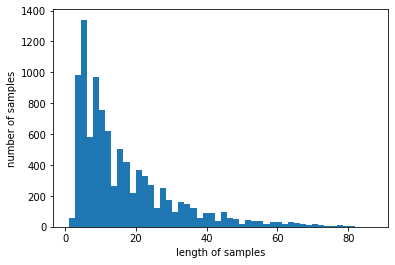

In [47]:
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [48]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [49]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 96.27083333333334


In [50]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_val = pad_sequences(X_val, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [56]:
y_train = train_y
y_val = validation_y
y_test = test_y

In [51]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [52]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(3, activation='softmax'))

In [53]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [57]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_data = (X_val, y_val))

Epoch 1/15
150/150 [==============================] - 11s 61ms/step - loss: 0.7470 - acc: 0.6627 - val_loss: 0.5529 - val_acc: 0.7742

Epoch 00001: val_acc improved from -inf to 0.77417, saving model to best_model.h5
Epoch 2/15
150/150 [==============================] - 9s 62ms/step - loss: 0.4699 - acc: 0.8156 - val_loss: 0.5066 - val_acc: 0.7875

Epoch 00002: val_acc improved from 0.77417 to 0.78750, saving model to best_model.h5
Epoch 3/15
150/150 [==============================] - 9s 62ms/step - loss: 0.3867 - acc: 0.8496 - val_loss: 0.4937 - val_acc: 0.7983

Epoch 00003: val_acc improved from 0.78750 to 0.79833, saving model to best_model.h5
Epoch 4/15
150/150 [==============================] - 9s 60ms/step - loss: 0.3427 - acc: 0.8714 - val_loss: 0.5026 - val_acc: 0.7967

Epoch 00004: val_acc did not improve from 0.79833
Epoch 5/15
150/150 [==============================] - 9s 60ms/step - loss: 0.3075 - acc: 0.8847 - val_loss: 0.5343 - val_acc: 0.7908

Epoch 00005: val_acc did no

In [59]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

38/38 [==============================] - 1s 15ms/step - loss: 0.4941 - acc: 0.8050

 테스트 정확도: 0.8050


koelectra

https://github.com/jiwonny/nlp_emotion_classification/blob/master/NSMC_KoELECTRA.ipynb


https://blog.naver.com/horajjan/221739630055


https://heegyukim.medium.com/huggingface-koelectra%EB%A1%9C-nsmc-%EA%B0%90%EC%84%B1%EB%B6%84%EB%A5%98%EB%AA%A8%EB%8D%B8%ED%95%99%EC%8A%B5%ED%95%98%EA%B8%B0-1a23a0c704af

In [ ]:
from transformers import ElectraModel, ElectraTokenizer
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator")
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/431M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

Downloading:   0%|          | 0.00/257k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

In [ ]:
tokenizer.tokenize("[CLS] 한국어 ELECTRA를 공유합니다. [SEP]")

['[CLS]', '한국어', 'EL', '##EC', '##TRA', '##를', '공유', '##합니다', '.', '[SEP]']

In [ ]:
import tensorflow as tf
import torch

from transformers import ElectraTokenizer
from transformers import ElectraForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

In [ ]:
MAX_LEN = 128

def getInputs(dataset):
  data = dataset.copy(deep=True)

  sentences = data['comment']

  sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
  
  tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator", do_lower_case=False)
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  attention_masks = []
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

  return input_ids, attention_masks

In [ ]:
def getIndex(dataset):
  data = dataset.copy(deep = True)
  input_index = data.index.tolist()
  return torch.tensor(input_index)

In [ ]:
ratings_labels = train['label'].values
val_labels = validation['label'].values
test_labels = test['label'].values
ratings_inputs, ratings_masks = getInputs(train)
val_inputs, val_masks = getInputs(validation)
test_inputs, test_masks = getInputs(test)

In [ ]:
# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(ratings_inputs)
train_labels = torch.tensor(ratings_labels)
train_masks = torch.tensor(ratings_masks)

validation_inputs = torch.tensor(val_inputs)
validation_labels = torch.tensor(val_labels)
validation_masks = torch.tensor(val_masks)			

test_index = getIndex(test)
test_inputs = torch.tensor(test_inputs)
test_masks = torch.tensor(test_masks)

In [ ]:
batch_size = 4

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_index, test_inputs, test_masks)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
# ELECTRA 모델 생성

model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels = 3)
model.cuda()

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로직과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   500  of  2,400.    Elapsed: 0:00:40.
  Batch 1,000  of  2,400.    Elapsed: 0:01:21.
  Batch 1,500  of  2,400.    Elapsed: 0:02:01.
  Batch 2,000  of  2,400.    Elapsed: 0:02:41.

  Average training loss: 1.10
  Training epcoh took: 0:03:14

Running Validation...
  Accuracy: 0.34
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch   500  of  2,400.    Elapsed: 0:00:40.
  Batch 1,000  of  2,400.    Elapsed: 0:01:21.
  Batch 1,500  of  2,400.    Elapsed: 0:02:01.
  Batch 2,000  of  2,400.    Elapsed: 0:02:41.

  Average training loss: 1.10
  Training epcoh took: 0:03:14

Running Validation...
  Accuracy: 0.34
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
  Batch   500  of  2,400.    Elapsed: 0:00:40.
  Batch 1,000  of  2,400.    Elapsed: 0:01:21.
  Batch 1,500  of  2,400.    Elapsed: 0:02:01.
  Batch 2,000  of  2,400.    Elapsed: 0:02:42.

  Average training loss: 1.10
  Training epcoh t

In [ ]:
# test
tmp_test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=1)
test_result = test.copy(deep = True)
test_result['Predicted'] = 'default'
classes = [0, 1]

#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(tmp_test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_index, b_input_ids, b_input_mask = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    idx = b_index.item()
    test_result['Predicted'][idx] = classes[np.argmax(logits)]
    

    nb_eval_steps += 1

print("")
print("Test took: {:}".format(format_time(time.time() - t0)))